In [798]:
import obspy
import instaseis
import matplotlib.pyplot as plt
import numpy as np
import mpld3
from scipy.signal import hilbert
#mpld3.enable_notebook()
%matplotlib inline

### Read data

Text(0.5,0,'time (s)')

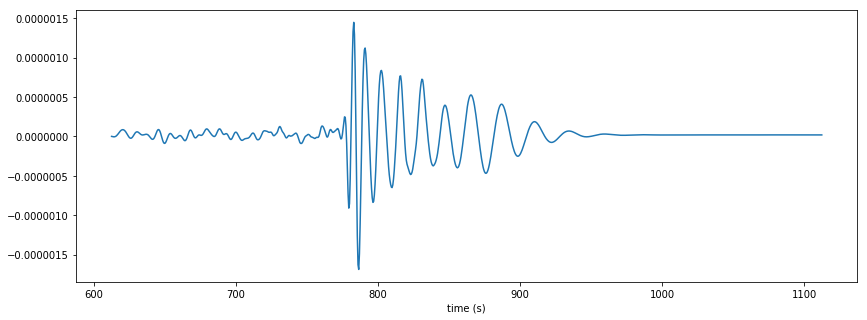

In [799]:
st = obspy.read("../data/test_sac_data/B00101Z00.sac")
#st.resample(10.0)
r_start = st[0].stats.starttime
r_start = st[0].stats.sac['b']
t_0 = 300.0
t_1 = 800.0
tr = st[0].trim(starttime=st[0].stats.starttime+t_0,endtime=st[0].stats.starttime+t_1)
tr.integrate()
dist_km = tr.stats.sac['dist']
time = np.linspace(r_start+t_0,r_start+t_1,len(tr.data))
veloc = dist_km / time
fig = plt.figure(figsize=(14,5))
plt.plot(time,st[0].data)
plt.xlabel('time (s)')

-0.999000999000999 0.999000999000999 1001 0.001998001998001998


Text(0.5,0,'frequency (Hz)')

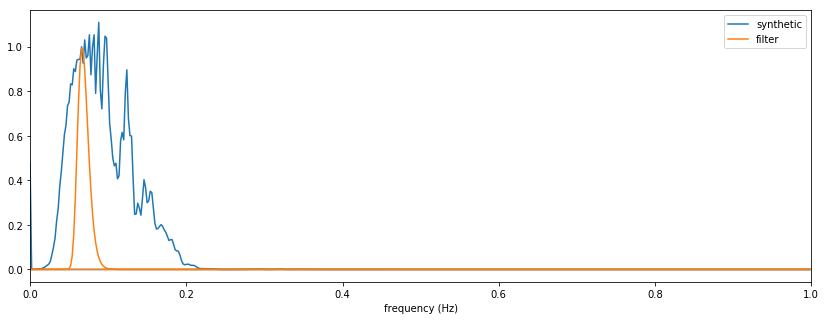

In [800]:
F_data = np.fft.fft(st[0].data)
freqs = np.fft.fftfreq(len(st[0].data),d = st[0].stats.delta)
print np.min(freqs),np.max(freqs),len(freqs),np.diff(freqs)[0]
F_filter = np.zeros(len(F_data))
alpha=50.0
period=15.0
omega_0 = 1/period
for i in range(0,len(freqs)):
    if freqs[i] > 0.0:
        fact = -alpha*((freqs[i]-omega_0)/(freqs[i]))**2
        F_filter[i] = np.exp(fact)

nfreqs = len(freqs)

#remove negative frequencies
F_data[int(nfreqs/2):] = 0
F_filter[int(nfreqs/2):] = 0

fig = plt.figure(figsize=(14,5))
plt.plot(freqs,np.abs(F_data**2)/np.abs(np.max(F_data**2)),label='synthetic')
plt.plot(freqs,F_filter,label='filter')
plt.xlim([0,1])
plt.legend()
plt.xlabel('frequency (Hz)')

#plt.xlim([0,0.5])

Text(0.5,0,'time (s)')

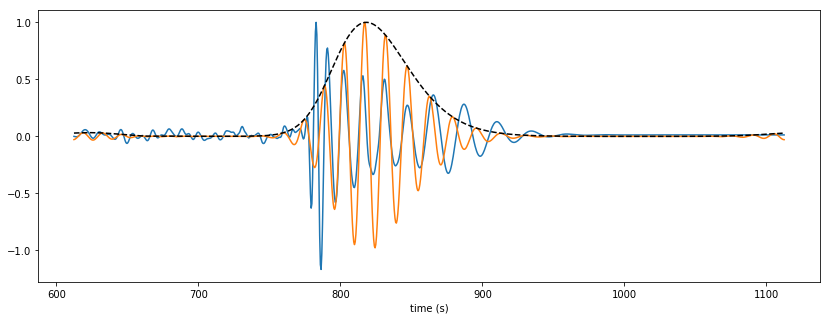

In [801]:
F_filtered = F_data * F_filter
filtered_data = np.fft.ifft(F_filtered)
filtered_data = filtered_data.real
fig = plt.figure(figsize=(14,5))
ansig = hilbert(filtered_data.real)
env = np.abs(ansig)

plt.plot(time,st[0].data/np.max(st[0].data))
plt.plot(time,filtered_data/np.max(filtered_data))
plt.plot(time,env/np.max(env),c='k',linestyle='--')
plt.xlabel('time (s)')

### Do MFT with Gaussian filters

In [802]:
def gauss_filter(data,sampling_rate,w_0,alpha,return_filter=False):
    F_data = np.fft.fft(data)
    freqs = np.fft.fftfreq(len(data),d = 1/sampling_rate)
    F_filter = np.zeros(len(F_data))
    for i in range(0,len(freqs)):
        if freqs[i] > 0.0:
            fact = -alpha*((freqs[i]-w_0)/(freqs[i]))**2
            F_filter[i] = np.exp(fact)
    nfreqs = len(freqs)
    
    #remove negative frequencies
    F_data[int(nfreqs/2):] = 0
    F_filter[int(nfreqs/2):] = 0
    
    F_filtered = F_filter * F_data
    data_filtered = np.fft.ifft(F_filtered)
    if return_filter == False:
        return data_filtered
    else:
        return data_filtered,F_filter[0:int(nfreqs/2)]

In [803]:
gaussian_filters = []
periods = np.linspace(5.0,50.0,45.)
gabor_matrix_gauss = np.zeros((len(time),len(periods)))
env_max_vel_gauss = []
env_max_per_gauss = []
for i,period in enumerate(periods):

    dcol,gfilt = gauss_filter(tr.data,tr.stats.sampling_rate,w_0=(1/period),alpha=100.,return_filter=True)
    env = np.abs(hilbert(dcol.real))
    gaussian_filters.append(gfilt)
    
    if np.max(env) > 0.0:
        env_max_per_gauss.append(period)
        env_max_vel_gauss.append(veloc[np.argmax(env)])
    
    gabor_matrix_gauss[:,i] = env

np.savetxt('grp_vel_gaussian.txt',np.c_[env_max_per_gauss,env_max_vel_gauss],fmt='%5f')

/home/romaguir/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


### Do MFT with Butterworth filters

In [804]:
gabor_matrix_butter = np.zeros((len(time),len(periods)))
env_max_vel_butter = []
env_max_per_butter = []
for i,period in enumerate(periods):
    
    s1 = 1.2
    s2 = 1.8
    T_short = period/s1
    T_long = period + (period/s2)
    f_min = 1./T_long
    f_max = 1./T_short

    tr_c = tr.copy()
    tr_c.filter('bandpass',freqmin=f_min,freqmax=f_max,corners=8,zerophase=True)
    dcol = tr_c.data
    env = np.abs(hilbert(dcol.real))
    
    if np.max(env) > 0.0:
        env_max_per_butter.append(period)
        env_max_vel_butter.append(veloc[np.argmax(env)])
    
    gabor_matrix_butter[:,i] = env
    
np.savetxt('grp_vel_butterworth.txt',np.c_[env_max_per_butter,env_max_vel_butter],fmt='%5f')

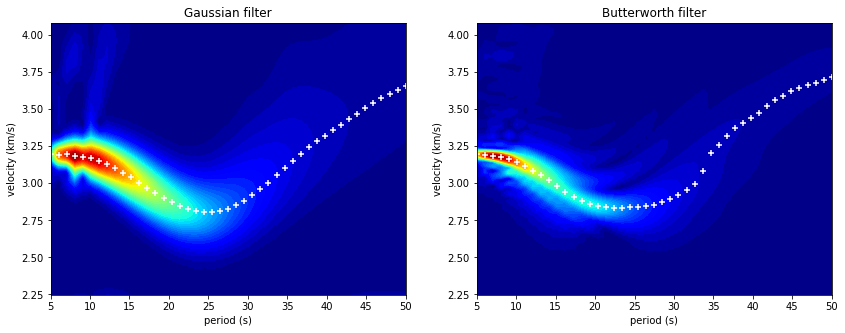

In [805]:
#normalize
gabor_matrix_gauss /= np.max(gabor_matrix_gauss)
gabor_matrix_butter /= np.max(gabor_matrix_butter)

#plot
fig,axes=plt.subplots(1,2,figsize=[14,5])
axes[0].contourf(periods,veloc,gabor_matrix_gauss,cmap='jet',levels=np.linspace(0,1,50))
axes[0].scatter(env_max_per_gauss,env_max_vel_gauss,c='w',alpha=1.0,marker='+')
axes[1].contourf(periods,veloc,gabor_matrix_butter,cmap='jet',levels=np.linspace(0,1,50))
axes[1].scatter(env_max_per_butter,env_max_vel_butter,c='w',alpha=1.0,marker='+')
axes[0].set_xlabel('period (s)')
axes[0].set_ylabel('velocity (km/s)')
axes[1].set_xlabel('period (s)')
axes[1].set_ylabel('velocity (km/s)')
axes[0].set_title('Gaussian filter')
axes[1].set_title('Butterworth filter')
axes[0].set_xlim([5,50])
axes[1].set_xlim([5,50])
plt.show()

### Compare results with Computer Programs in Seismology tutorial

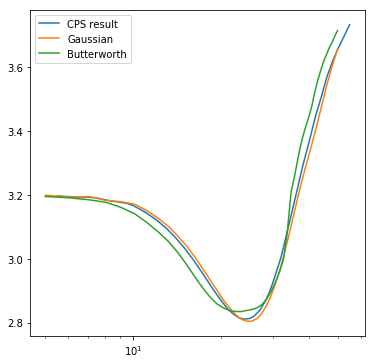

In [806]:
f = np.loadtxt('../data/hermann_halfspace_grp_vel.txt')
fig,ax = plt.subplots(1,figsize=[6,6])
ax.semilogx(f[:,0],f[:,1],label='CPS result')
ax.semilogx(env_max_per_gauss,env_max_vel_gauss,label='Gaussian')
ax.semilogx(env_max_per_butter,env_max_vel_butter,label='Butterworth')
ax.legend()

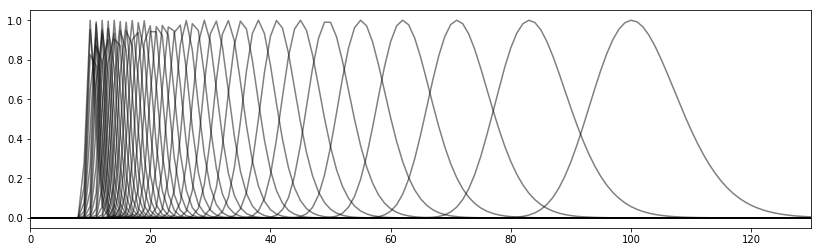

In [807]:
fig = plt.figure(figsize=[14,4])
for filt in gaussian_filters:
    plt.plot(filt,c='k',alpha=0.5)
plt.xlim([0,130])
plt.show()